Standard convolution method with downscaling.

In [135]:
import torch
from torch.nn import Conv2d, ConvTranspose2d
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage, PILToTensor
from torch.nn import Upsample
import torch.nn.functional as F

image = torch.Tensor([[
    [1,0,1],
    [0,1,0],
    [1,0,1]]]
)

model = Conv2d(1, 1, 3, stride=1)
X = model.weight[0][0]
computed = model.bias + X[0][0] + X[1][1] + X[2][2] + X[2][0] + X[0][2]
print (model(image)[0][0], computed, model(image)[0][0] == computed )

tensor([-0.6168], grad_fn=<SelectBackward0>) tensor([-0.6168], grad_fn=<AddBackward0>) tensor([True])


Upscaling using Transpose convolution

In [136]:
upscaling_model = torch.nn.ConvTranspose2d(1, 1, 3, stride=1)
X = model.weight[0][0]
print (upscaling_model(upscaling_model(image)), )

tensor([[[ 0.0759, -0.0579,  0.2270, -0.1662,  0.2215, -0.0493,  0.0711],
         [ 0.0205,  0.1084, -0.0766,  0.1839, -0.0406,  0.0607,  0.0459],
         [ 0.0836, -0.0644,  0.1791, -0.0462,  0.0731,  0.0606,  0.0219],
         [ 0.0192,  0.0699,  0.0599, -0.0295,  0.1654, -0.0125,  0.0453],
         [ 0.0450,  0.0622, -0.0280,  0.1587, -0.0522,  0.1332,  0.0122],
         [ 0.0473,  0.0441,  0.0669,  0.0580,  0.0490,  0.0849,  0.0446],
         [ 0.0460,  0.0450,  0.0499,  0.0415,  0.0733,  0.0413,  0.0769]]],
       grad_fn=<SqueezeBackward1>)


(500, 726)


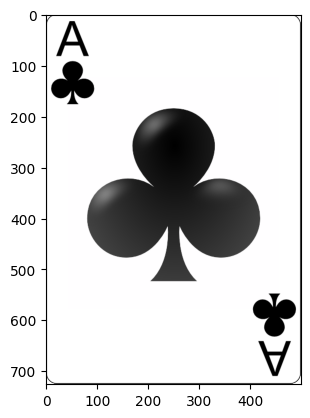

In [137]:
src = Image.open('/Users/venkat/Documents/GitHub/ai/diffusion/Noise Samples/aces/ace_of_clubs.png')
print (src.size)
plt.imshow(src)


(500, 726)
(1026, 1478)


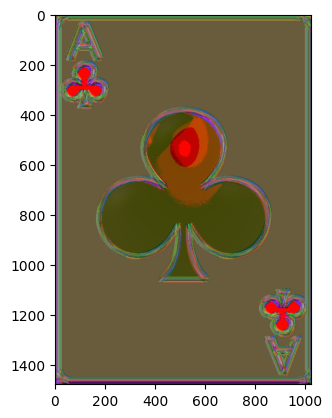

In [138]:
src_without_alpha = src.convert("RGB") # remove alpha

image = ToTensor()(src_without_alpha)
print (src.size)

upscaling_model = torch.nn.ConvTranspose2d(3, 3, 28, stride=2, padding=0)
image_upscaled = upscaling_model(image)
img_upscaled = ToPILImage()(image_upscaled)
print (img_upscaled.size)

plt.imshow(img_upscaled)

Upscale and downscale images using interpolate functionality

(250, 363)


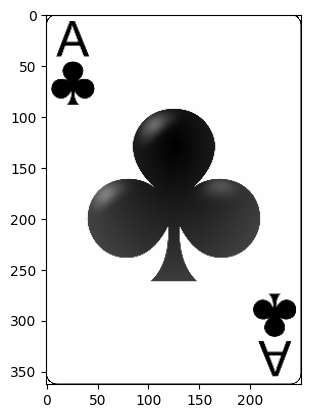

In [139]:
src_without_alpha = src.convert("RGB") # remove alpha
image = ToTensor()(src_without_alpha)
img_upscaled = ToPILImage()(F.interpolate(image.unsqueeze(0), scale_factor=0.5, mode='nearest').squeeze(0))
print (img_upscaled.size)
plt.imshow(img_upscaled)

(750, 1089)


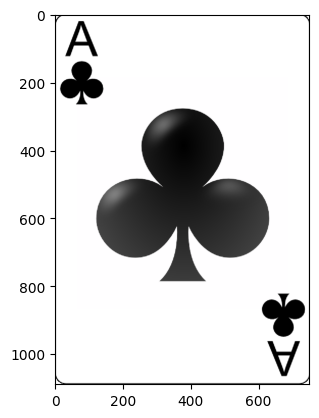

In [140]:
src_without_alpha = src.convert("RGB") # remove alpha
image = ToTensor()(src_without_alpha)
img_upscaled = ToPILImage()(F.interpolate(image.unsqueeze(0), scale_factor=1.5, mode='nearest').squeeze(0))
print (img_upscaled.size)
plt.imshow(img_upscaled)

3.421912447146744e-05
69997928632.4084
(-0.5434526205062867+1.3877787807814457e-16j)
(1.2160109281539917-6.279698983036042e-16j)


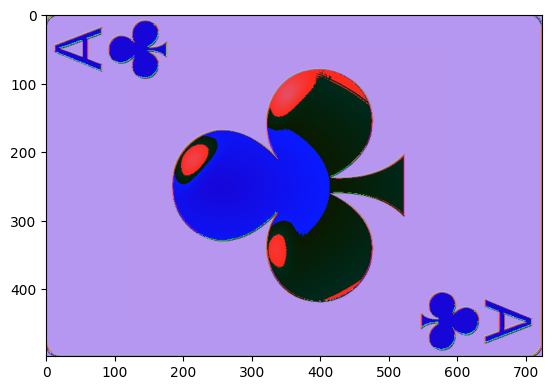

In [141]:
from numpy.fft import fft2, ifft2
from scipy.signal import wiener

def myconv(image):
    print ("Convolution : ", image.shape)
    conv = Conv2d(in_channels=3, out_channels=3, kernel_size=3)
    output = conv(image)
    
    return output


def mydeconv(image):
    image = image.detach().numpy()

    dft = np.fft.fft2(image)
    pspec = (np.abs(dft))**2

    noise = 0

    wiener = pspec/(pspec+noise)
    wiener = wiener*dft

    restored = np.fft.ifft2(wiener)

    filtered_img = np.real(restored)
    print(np.amin(restored))
    print(np.amax(restored))

    return filtered_img.T

tf = transforms.Compose([
    ToTensor(),
    Conv2d(in_channels=3, out_channels=3, kernel_size=3),
    mydeconv,
    ToPILImage()
])
restored = tf(src_without_alpha)
plt.imshow(restored)
